In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyxdf

%matplotlib inline

# Analyze screen flicker delay/jitter

## Load lsl recording

In [36]:
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-001_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-005_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_psychopy_run-001_eeg.xdf'
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
# fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf'
# fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-slow_erp_test_run-003_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_slow_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_fast_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new-monitor-test_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new_monitor_test_run-002_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_timing_accuracy_test_run-003_eeg.xdf"
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_timing_test-001_eeg.xdf"
fpath = "C:/Users/Experiment/Documents/BCI/AmarE/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_timing_test_run-001_eeg.xdf"
fpath = "C:/Users/Experiment/Documents/BCI/AmarE/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-7m_cable_test_run-001_eeg.xdf"
fpath = "C:/Users/Experiment/Documents/BCI/AmarE/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_test_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fpath)

for stream in streams:
    print(stream['info']['name'])

['ScreenSensorStream']
['MarkerStream']


In [29]:
# Load timestamps
sequence_stream = [s for s in streams if s['info']['name'][0] == 'SequenceStream'][0]
sensor_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSensorStream'][0]
# marker_stream = [s for s in streams if s['info']['name'][0] == 'MarkerStream'][0]

In [30]:
np.unique(sequence_stream['time_series'])

array([0, 1], dtype=int8)

In [31]:
timestamps = sequence_stream['time_stamps']
timeseries = sequence_stream['time_series']
timestamps_sensor = sensor_stream['time_stamps']
timeseries_sensor = sensor_stream['time_series']
print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor.shape)


LSL Timestamps: (961,)
Sensor timestamps (2610,)


In [32]:
# timeseries = (np.ravel(timeseries[1:]) == '1').astype(int)
# timestamps = timestamps[1:]

In [33]:
start_timestamp = timestamps[0]
end_timestamp = timestamps[-1] + 0.02
print(start_timestamp)
print(end_timestamp)

timeseries_sensor = timeseries_sensor[(timestamps_sensor >= start_timestamp) & (timestamps_sensor <= end_timestamp)]
timestamps_sensor = timestamps_sensor[(timestamps_sensor >= start_timestamp) & (timestamps_sensor <= end_timestamp)]
timestamps = timestamps - start_timestamp
timestamps_sensor = timestamps_sensor - start_timestamp
print('LSL Timestamps shape:', timestamps.shape)
print('LSL Timeseries shape:', timeseries.shape)
print('Sensor timestamps shape:', timestamps_sensor.shape)
print('Sensor timeseries shape:', timeseries_sensor.shape)

%matplotlib qt
plt.scatter(timestamps, timeseries.sum(axis=1) // 8, label='expected', marker='o')
plt.scatter(timestamps_sensor, timeseries_sensor, label='sensor', marker='x')
plt.legend()
plt.show()


3033263.803455354
3033393.7381557114
LSL Timestamps shape: (961,)
LSL Timeseries shape: (961, 8)
Sensor timestamps shape: (2604,)
Sensor timeseries shape: (2604, 1)


In [22]:
# Remove sensor jitter
def remove_jitter(timestamps, timeseries, tolerance=0.005):
    filtered = [timestamps[0]]
    filtered_timeseries = [timeseries[0]]
    # print(filtered)
    for timestamp, val in zip(timestamps[1:], timeseries[1:]):
        if timestamp - filtered[-1] >= tolerance:
            filtered.append(timestamp)
            filtered_timeseries.append(val)
    return np.array(filtered), np.array(filtered_timeseries)

timestamps_sensor, timeseries_sensor = remove_jitter(timestamps_sensor, timeseries_sensor)

print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor.shape)
plt.plot(timestamps, timeseries, label='expected')
plt.plot(timestamps_sensor, timeseries_sensor, label='sensor')
plt.legend()
plt.show()

LSL Timestamps: (961,)
Sensor timestamps (924,)


In [34]:
plt.plot(timestamps, timeseries.sum(axis=1) // 8, label='expected')
plt.plot(timestamps_sensor, timeseries_sensor, label='sensor')
plt.legend()
plt.show()

In [24]:
# Filter sensor jitter
df_timestamps = pd.DataFrame(timestamps, columns=['timestamp'])
df_timestamps_sensor = pd.DataFrame(timestamps_sensor, columns=['timestamp_sensor'])

df_merged = pd.merge_asof(df_timestamps, df_timestamps_sensor, left_on='timestamp', right_on='timestamp_sensor', direction='nearest', tolerance=0.1)
print(df_merged.shape)
print(df_merged.head())
print('\n# of NaNs:')
print(df_merged.isna().sum())

(961, 2)
   timestamp  timestamp_sensor
0   0.000000          0.097880
1   0.078923          0.097880
2   0.229147          0.248966
3   0.329029          0.347944
4   0.479004          0.498856

# of NaNs:
timestamp            0
timestamp_sensor    37
dtype: int64


In [25]:
%matplotlib qt

plt.scatter(df_merged['timestamp'], np.ones_like(df_merged['timestamp']), label='expected', marker='o')
plt.scatter(df_merged['timestamp_sensor'], np.ones_like(df_merged['timestamp_sensor']), label='actual', marker='x')
plt.legend()
plt.show()

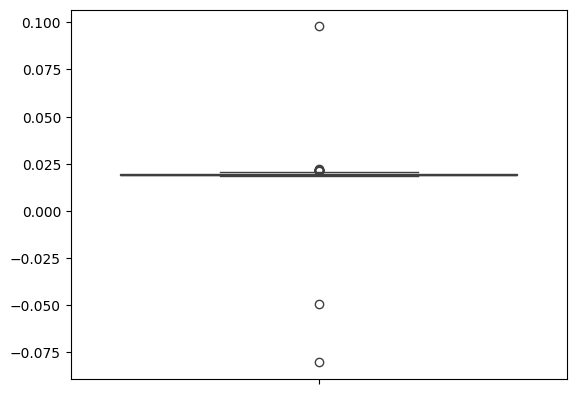

In [26]:
%matplotlib inline
plt.clf()
plt.cla()
sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'])
plt.show()


Shape before: (961, 2)
Shape after: (961, 2)

# of NaNs:
timestamp           41
timestamp_sensor    78
dtype: int64


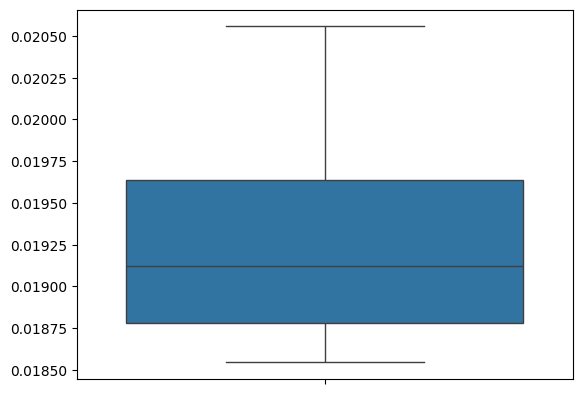

0.019046682648736213


In [27]:
# Ignore first N seconds
start_time = 5
print('Shape before:', df_merged.shape)
df_merged['timestamp'] = df_merged['timestamp'].where(df_merged['timestamp'] > start_time)
df_merged['timestamp_sensor'] = df_merged['timestamp_sensor'].where(df_merged['timestamp_sensor'] > start_time)
print('Shape after:', df_merged.shape)
print('\n# of NaNs:')
print(df_merged.isna().sum())

sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'], showfliers=False)
plt.show()
print((df_merged['timestamp_sensor'] - df_merged['timestamp']).mean())